In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [2]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie/008C0665790F0763/ComboPanNeuronalGCaMP6/938/938ss2onc250regcdFF20sMpsfkf250Smith0_4_60TS.mat


In [3]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(6011, 250)

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/008C0665790F0763/ComboPanNeuronalGCaMP6/938/938ss2onc250regcdFF20sMpsfkf250Smith0_4_60IC.nii


In [5]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(165, 111, 10, 250)

In [6]:
S=data.shape
S

(165, 111, 10, 250)

Z-score

In [7]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [8]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [9]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [16]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/008C0665790F0763/ComboPanNeuronalGCaMP6/938/938Registration/JFRCTransformedLargefullpsftrimmed.nii


In [17]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [18]:
RegionName

['OL',
 'VLNP',
 'VMNP',
 'AL',
 'MB',
 'LH',
 'SNP',
 'CX',
 'LX',
 'INP',
 'PENP',
 'GNG']

# Average in masks to sort components by brain region

In [19]:
Dmaps.shape

(165, 111, 10, 250)

In [20]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [21]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [22]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [23]:
J

[4]

OL


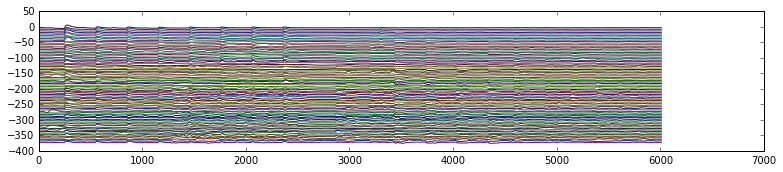

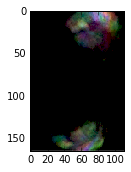

VLNP


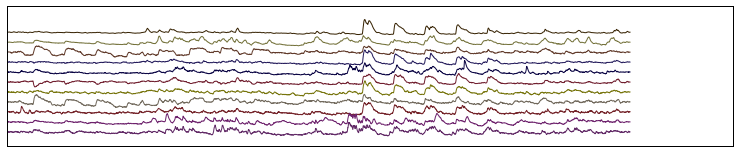

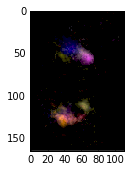

VMNP


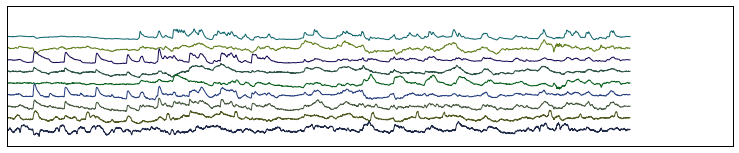

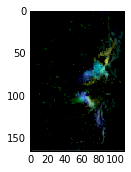

AL


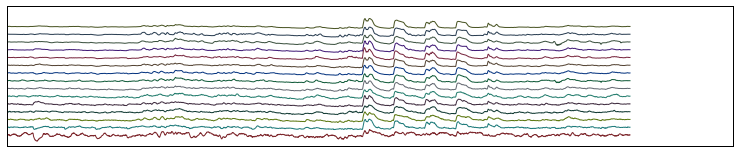

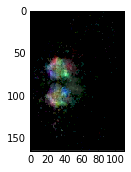

MB


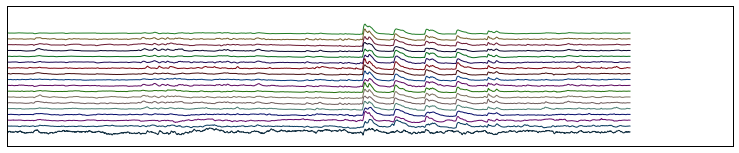

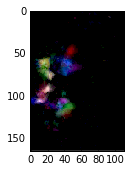

LH


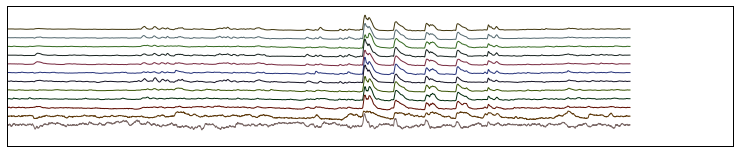

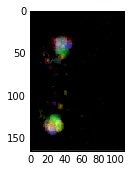

SNP


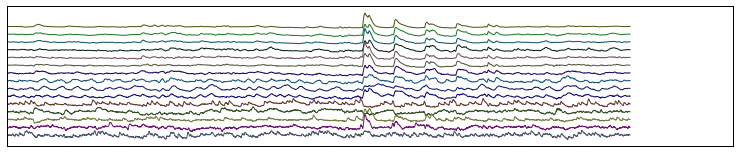

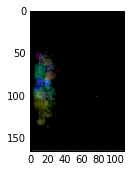

CX


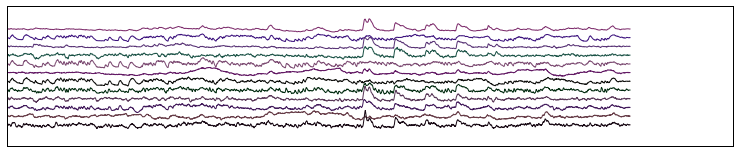

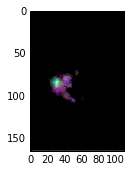

INP


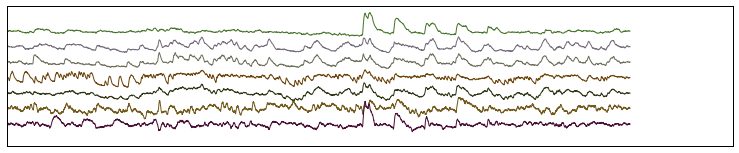

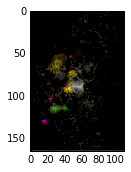

PENP


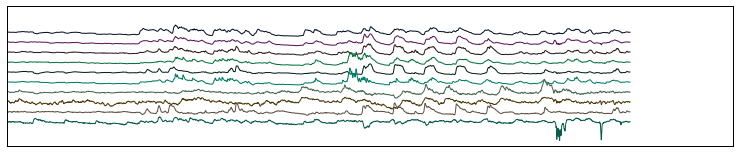

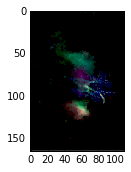

GNG


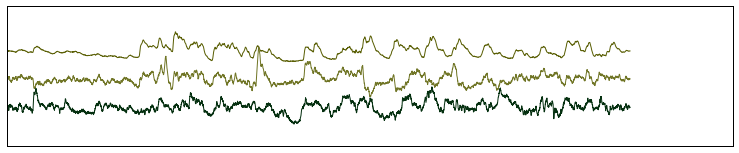

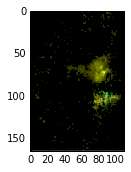

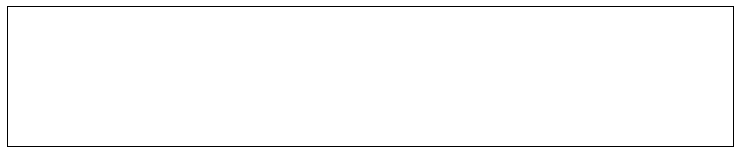

In [24]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [30]:
BadICs=[92,99,72,156,216,197,232]

In [31]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

8
14
19
25
32
34
40
42
55
56
58
60
61
66
67
69
70
93
94
95
96
98
103
105
106
108
111
113
115
118
119
120
125
126
128
129
130
132
136
137
138
139
142
147
149
150
151
152
155
158
160
162
164
165
166
167
168
171
172
174
176
177
179
194
199
200
205
210
211
217
225
229
230
234
OL


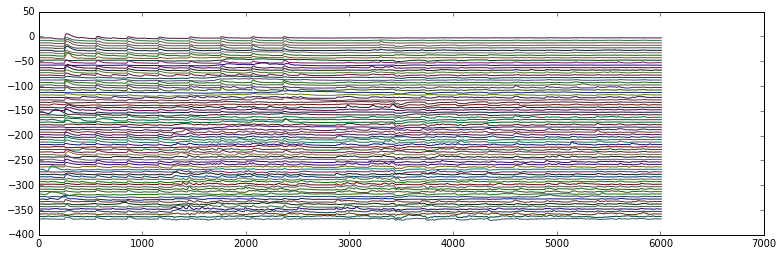

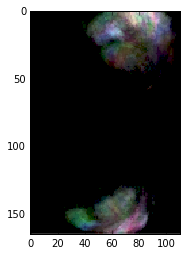

13
85
97
104
121
123
143
154
159
181
190
VLNP


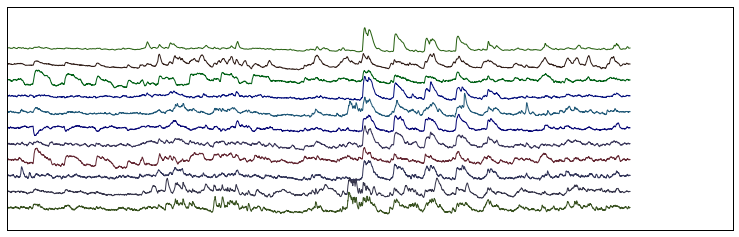

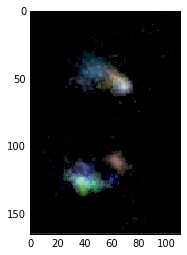

45
74
76
78
101
117
157
VMNP


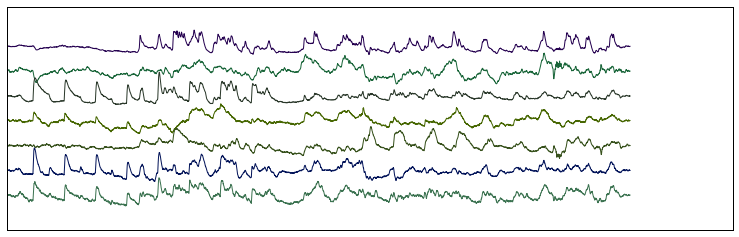

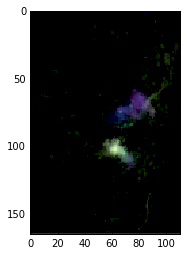

0
9
12
24
26
27
33
54
64
82
83
90
107
116
212
AL


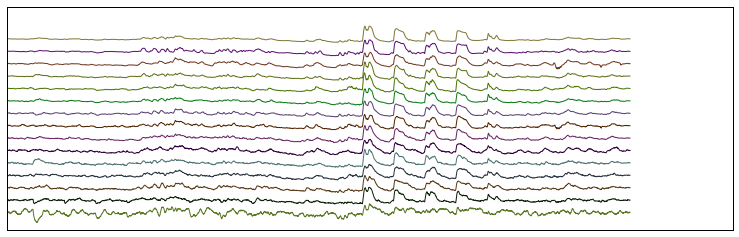

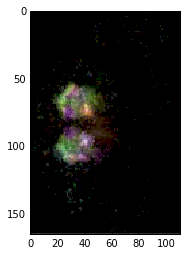

5
18
22
23
29
37
39
41
43
44
47
48
53
62
63
68
86
228
MB


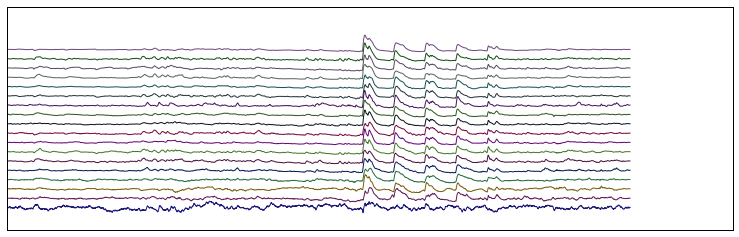

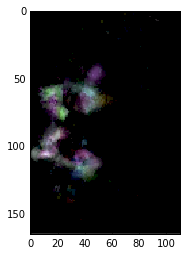

1
3
4
6
7
10
15
16
17
73
175
227
LH


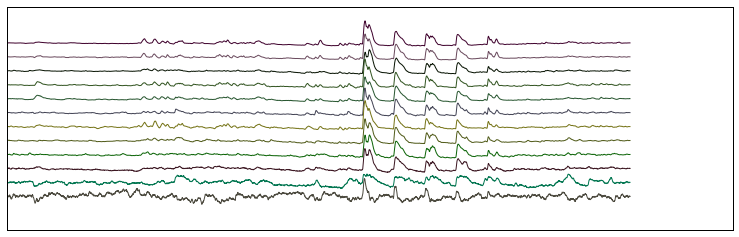

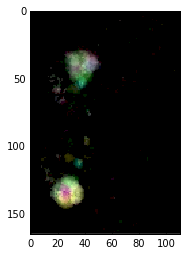

2
28
35
71
79
84
122
140
146
169
193
208
215
221
236
SNP


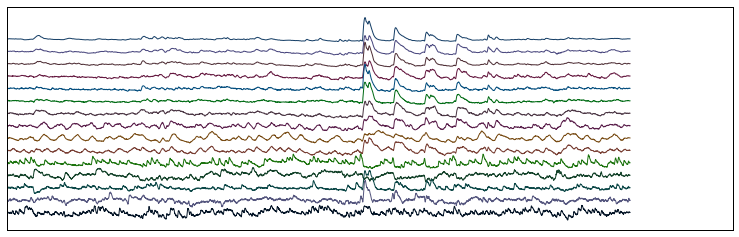

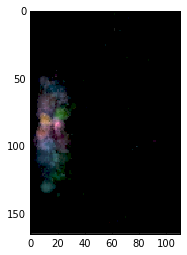

80
81
114
127
133
135
148
153
182
186
207
223
CX


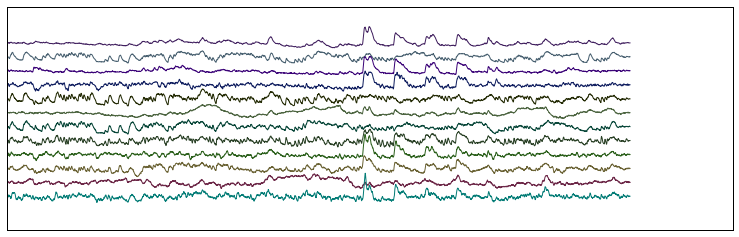

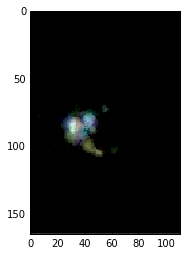

75
77
89
102
109
204
214
INP


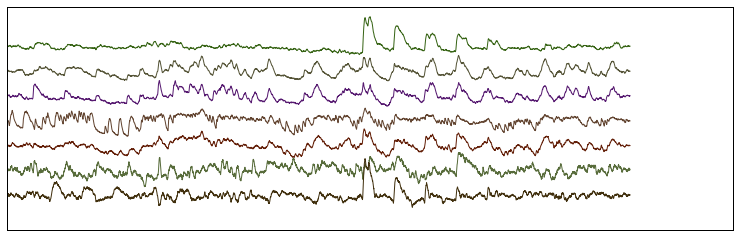

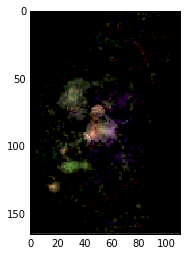

20
30
36
38
46
50
112
PENP


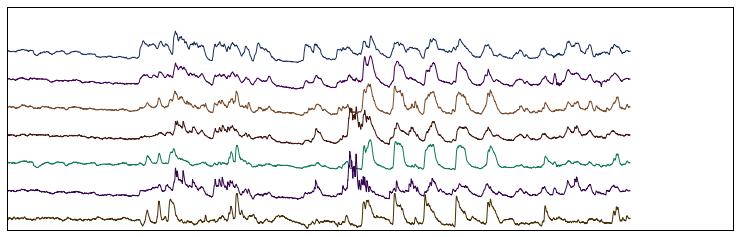

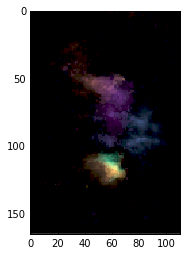

21
239
GNG


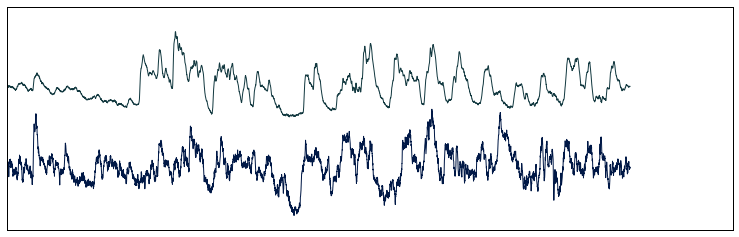

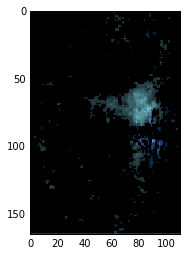

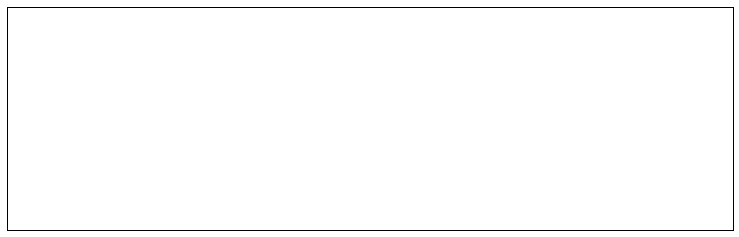

In [32]:
pylab.rcParams['figure.figsize'] = (13, 4)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.3)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

In [33]:
# Output number of component per region
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsV2.txt',NumberInLargeRegion)